In [1]:
"""
Data Set Information:
LIMIT_BAL: Amount of credit given (in New Taiwan dollars) including both the individual consumer credit and supplemental credit for family.
SEX: Gender (1 = male; 2 = female). 
EDUCATION: Education (1 = graduate school; 2 = university; 3 = high school; 4 = other). 
MARRIAGE:(1 = married; 2 = single; 3 = others). 
AGE: Age (year). 
PAY_0 - PAY_6: History of past payment. 0 = the repayment status in September, 2005; 1 = the repayment status in August, 2005; . . .; 6 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
BILL_AMT1-BILL_AMT6: Amount of bill statement (in New Taiwan dollars). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005. 
PAY_AMT1-PAY_AMT6: Amount of previous payment (in New Taiwan dollars).
default payment next month: positive class: default | negative class: pay
"""


'\nData Set Information:\nLIMIT_BAL: Amount of credit given (in New Taiwan dollars) including both the individual consumer credit and supplemental credit for family.\nSEX: Gender (1 = male; 2 = female). \nEDUCATION: Education (1 = graduate school; 2 = university; 3 = high school; 4 = other). \nMARRIAGE:(1 = married; 2 = single; 3 = others). \nAGE: Age (year). \nPAY_0 - PAY_6: History of past payment. 0 = the repayment status in September, 2005; 1 = the repayment status in August, 2005; . . .; 6 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.\nBILL_AMT1-BILL_AMT6: Amount of bill statement (in New Taiwan dollars). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005. \nPAY_AMT1-PAY_

In [2]:
# Importing useful libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


C:\Users\hakob\Anaconda3\envs\pydata\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\hakob\Anaconda3\envs\pydata\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
default = pd.read_csv('credit_card_default.csv')

default.rename(columns=lambda x: x.lower(), inplace=True)

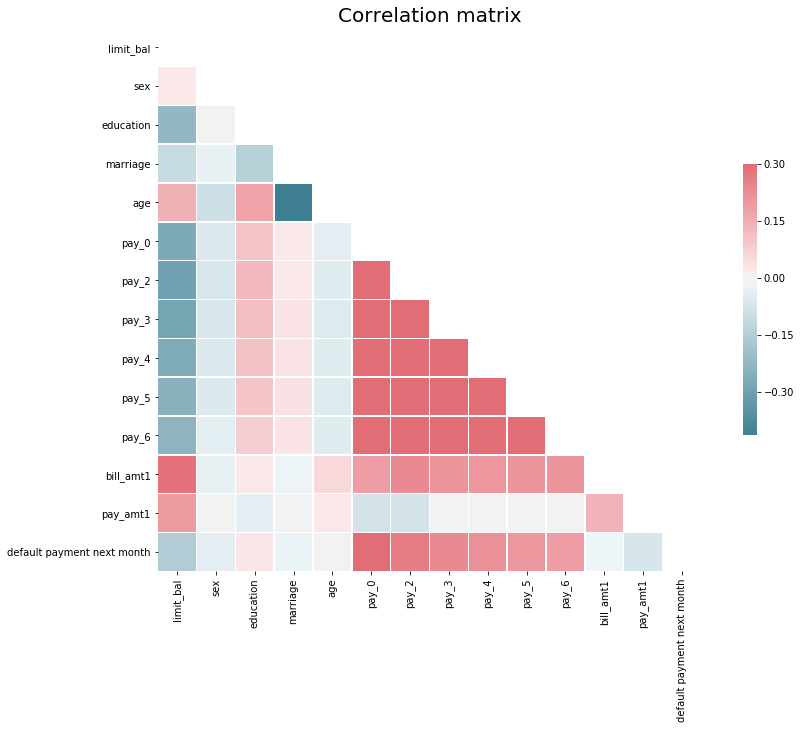

In [4]:
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 10))
# Compute the correlation matrix
corr = default.corr()
#print(corr)
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation matrix', 
          fontsize = 20)
plt.show()

In [5]:
# Base values: female, other_education, not_married
default['grad_school'] = (default['education'] == 1).astype('int')
default['university'] = (default['education'] == 2).astype('int')
default['high_school'] = (default['education'] == 3).astype('int')
default.drop('education', axis=1, inplace=True)

default['male'] = (default['sex']==1).astype('int')
default.drop('sex', axis=1, inplace=True)

default['married'] = (default['marriage'] == 1).astype('int')
default.drop('marriage', axis=1, inplace=True)

# For pay features if the <= 0 then it means it was not delayed
pay_features = ['pay_0','pay_2','pay_3','pay_4','pay_5','pay_6']
for p in pay_features:
    default.loc[default[p]<=0, p] = 0

default.rename(columns={'default payment next month':'default'}, inplace=True) 

In [6]:
default.head()

,limit_bal,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,pay_amt1,default,grad_school,university,high_school,male,married
0,20000,24,2,2,0,0,0,0,3913,0,1,0,1,0,0,1
1,120000,26,0,2,0,0,0,2,2682,0,1,0,1,0,0,0
2,90000,34,0,0,0,0,0,0,29239,1518,0,0,1,0,0,0
3,50000,37,0,0,0,0,0,0,46990,2000,0,0,1,0,0,1
4,50000,57,0,0,0,0,0,0,8617,2000,0,0,1,0,1,1


In [7]:
#Building the Model

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import RobustScaler

In [8]:
target_name = 'default'
X = default.drop('default', axis=1)
robust_scaler = RobustScaler()
X = robust_scaler.fit_transform(X)
y = default[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

In [9]:
def CMatrix(CM, labels=['pay','default']):
    df = pd.DataFrame(data=CM, index=labels, columns=labels)
    df.index.name='TRUE'
    df.columns.name='PREDICTION'
    df.loc['Total'] = df.sum()
    df['Total'] = df.sum(axis=1)
    return df

In [10]:
# Data frame for evaluation metrics
metrics = pd.DataFrame(index=['accuracy', 'precision', 'recall'], 
                      columns=['NULL','LogisticReg'])

In [11]:
"""Accuracy: the proportion of the total number of predictions that are correct
Precision: the proportion of positive predictions that are actually correct
Recall: the proportion of positive observed values correctly predicted as such

Ex: Suppose a computer program for recognizing dogs in photographs identifies 8 dogs in a picture containing 12 dogs and some cats. Of the 8 identified as dogs, 5 actually are dogs (true positives), while the rest are cats (false positives). The program's precision is 5/8 while its recall is 5/12.
In this application:

Accuracy: Overall how often the model predicts correctly defaulters and non-defaulters
Precision: When the model predicts default: how often is correct?
Recall: The proportion of actual defalters that the model will correctly predict as such

Which metric should I use?
False Positive: A person who will pay predicted as defaulter
False Negative: A person who defaults but was predicted to be a payer
False negatives are worse => look for a better recall
"""


"Accuracy: the proportion of the total number of predictions that are correct\nPrecision: the proportion of positive predictions that are actually correct\nRecall: the proportion of positive observed values correctly predicted as such\n\nEx: Suppose a computer program for recognizing dogs in photographs identifies 8 dogs in a picture containing 12 dogs and some cats. Of the 8 identified as dogs, 5 actually are dogs (true positives), while the rest are cats (false positives). The program's precision is 5/8 while its recall is 5/12.\nIn this application:\n\nAccuracy: Overall how often the model predicts correctly defaulters and non-defaulters\nPrecision: When the model predicts default: how often is correct?\nRecall: The proportion of actual defalters that the model will correctly predict as such\n\nWhich metric should I use?\nFalse Positive: A person who will pay predicted as defaulter\nFalse Negative: A person who defaults but was predicted to be a payer\nFalse negatives are worse => l

In [12]:
#the null model

y_pred_test = np.repeat(y_train.value_counts().idxmax(), y_test.size)
metrics.loc['accuracy','NULL'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','NULL'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','NULL'] = recall_score(y_pred=y_pred_test, y_true=y_test)

CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

C:\Users\hakob\Anaconda3\envs\pydata\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


PREDICTION,pay,default,Total
TRUE,,,
pay,4673,0,4673
default,1327,0,1327
Total,6000,0,6000


In [13]:
#Logistic regression

# 1. Import the estimator object (model)
from sklearn.linear_model import LogisticRegression

# 2. Create an instance of the estimator
logistic_regression = LogisticRegression(n_jobs=-1, random_state=15)

# 3. Use the trainning data to train the estimator
logistic_regression.fit(X_train, y_train)

# 4. Evaluate the model
y_pred_test = logistic_regression.predict(X_test)
metrics.loc['accuracy','LogisticReg'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','LogisticReg'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','LogisticReg'] = recall_score(y_pred=y_pred_test, y_true=y_test)
#Confusion matrix
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

C:\Users\hakob\Anaconda3\envs\pydata\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


PREDICTION,pay,default,Total
TRUE,,,
pay,4482,191,4673
default,900,427,1327
Total,5382,618,6000


In [14]:
#Making prediction

def make_ind_prediction(new_data):
    data = new_data.values.reshape(1, -1)
    data = robust_scaler.transform(data)
    prob = logistic_regression.predict_proba(data)[0][1]
    if prob >= 0.2:
        return 'Will default'
    else:
        return 'Will pay'

In [15]:
from collections import OrderedDict
new_customer = OrderedDict([('limit_bal', 500),('age', 50 ),('bill_amt1', 500),
                            ('pay_amt1', 0 ),('male', 1 ),('grad_school', 0 ),('university', 1 ), ('high_school', 0 ),
                            ('married', 1 ),('pay_0', -1 ),('pay_2', -1 ),('pay_3', -1 ),
                            ('pay_4', -1),('pay_5', -1), ('pay_6', -1)])

new_customer = pd.Series(new_customer)
make_ind_prediction(new_customer)

'Will default'

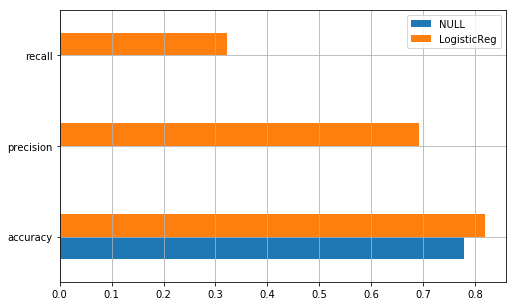

In [16]:
fig, ax = plt.subplots(figsize=(8,5))
metrics.plot(kind='barh', ax=ax)
ax.grid();

In [17]:
#K nearest neighbors


from sklearn.neighbors import KNeighborsClassifier  
classifier = KNeighborsClassifier(n_neighbors=17)  
classifier.fit(X_train, y_train) 


y_pred = classifier.predict(X_test)  


from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred)) 

[[4437  236]
 [ 874  453]]
             precision    recall  f1-score   support

          0       0.84      0.95      0.89      4673
          1       0.66      0.34      0.45      1327

avg / total       0.80      0.81      0.79      6000



In [18]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):  
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

In [19]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error

In [20]:
def make_ind_prediction(new_data):
    data = new_data.values.reshape(1, -1)
    data = robust_scaler.transform(data)
    prob = knn.predict_proba(data)[0][1]
    if prob >= 0.2:
        return 'Will default'
    else:
        return 'Will pay'

In [21]:
from collections import OrderedDict
new_customer = OrderedDict([('limit_bal', 5000),('age', 50 ),('bill_amt1', 500),
                            ('pay_amt1', 0 ),('male', 1 ),('grad_school', 0 ),('university', 1 ), ('high_school', 0 ),
                            ('married', 1 ),('pay_0', -1 ),('pay_2', -1 ),('pay_3', -1 ),
                            ('pay_4', -1),('pay_5', -1), ('pay_6', -1)])

new_customer = pd.Series(new_customer)
make_ind_prediction(new_customer)

'Will default'

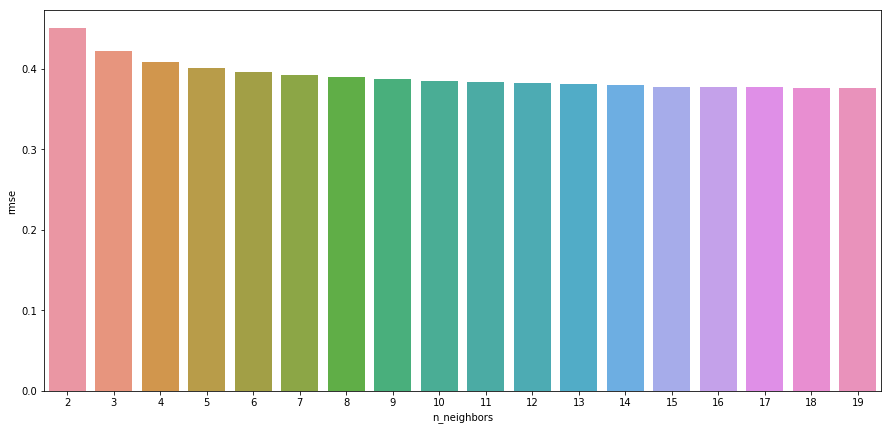

In [22]:
rmse_l = []
num = []
for n in range(2, 20):
    knn = neighbors.KNeighborsRegressor(n_neighbors=n)
    knn.fit(X_train, y_train)
    predicted = knn.predict(X_test)
    rmse_l.append(np.sqrt(mean_squared_error(y_test, predicted)))
    num.append(n)
    
df_plt = pd.DataFrame()
df_plt['rmse'] = rmse_l
df_plt['n_neighbors'] = num
ax = plt.figure(figsize=(15,7))
sns.barplot(data = df_plt, x = 'n_neighbors', y = 'rmse')
plt.show()


In [23]:
#17 nearest neighbors is the optimal number of neighbors

Text(0,0.5,'Mean Error')

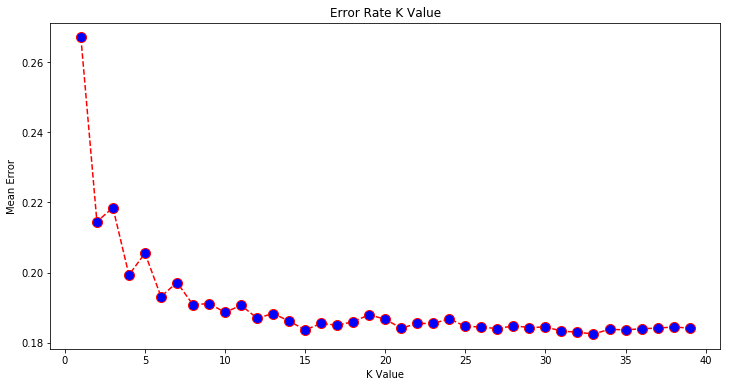

In [24]:
plt.figure(figsize=(12, 6))  
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')  
plt.xlabel('K Value')  
plt.ylabel('Mean Error') 

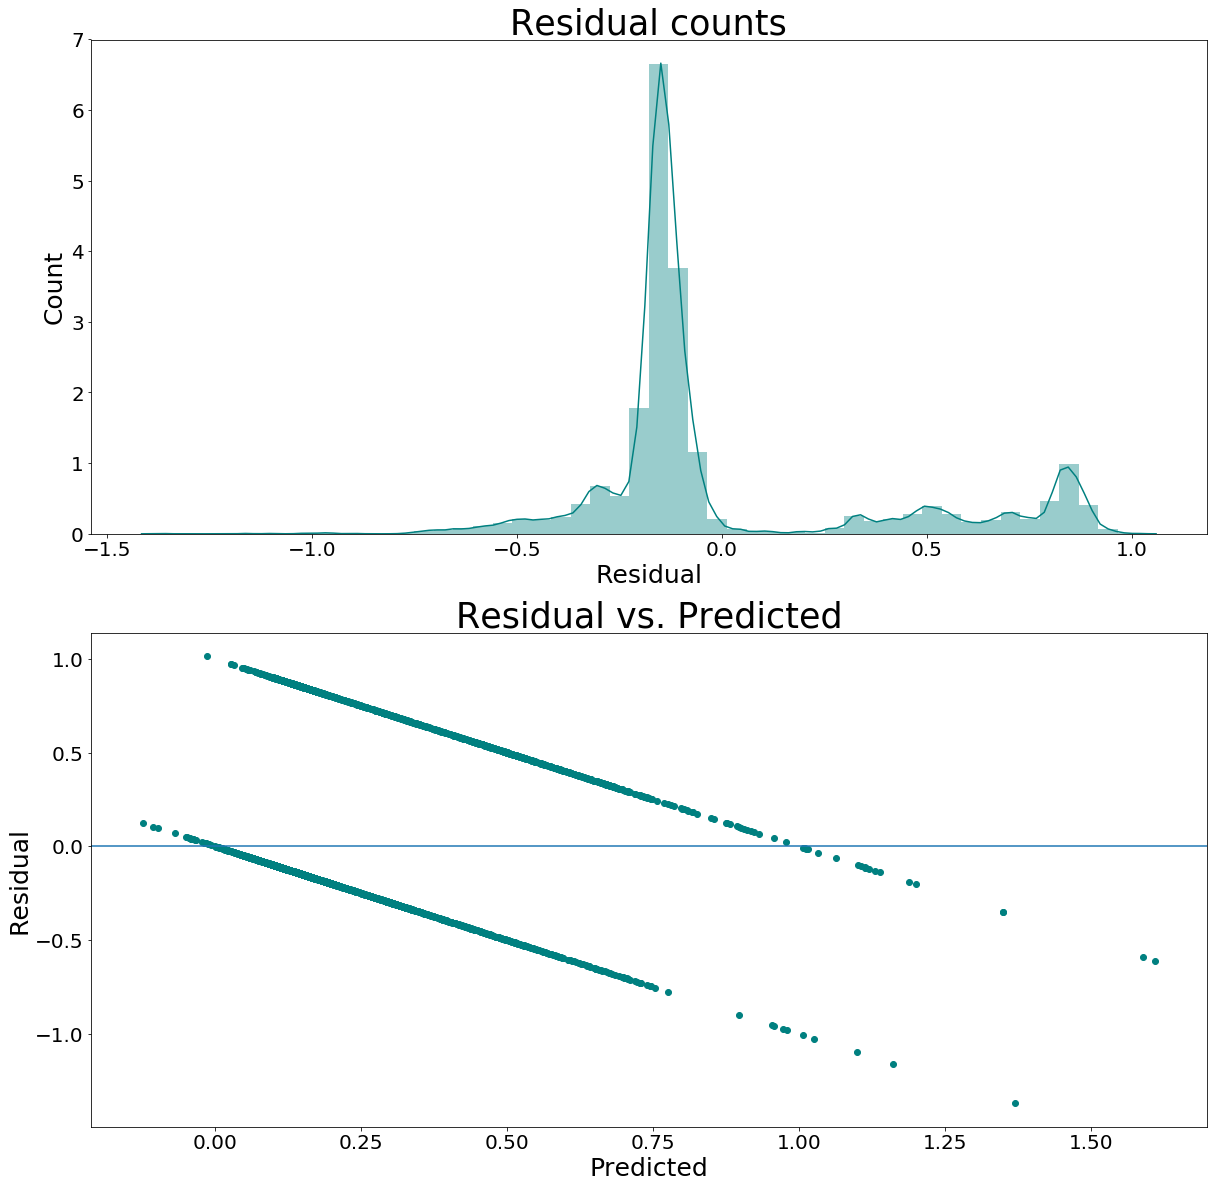

RMSE:
0.372447235426


In [25]:

from  sklearn  import  linear_model

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

predicted = regr.predict(X_test)
residual = y_test - predicted

fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot(211)
sns.distplot(residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Residual counts',fontsize=35)
plt.xlabel('Residual',fontsize=25)
plt.ylabel('Count',fontsize=25)

ax2 = plt.subplot(212)
plt.scatter(predicted, residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs. Predicted',fontsize=35)

plt.show()

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, predicted))
print('RMSE:')
print(rmse)

In [26]:
import pickle

with open('tasemodel.pkl', 'wb') as fid:
    pickle.dump(logistic_regression, fid,2)  

In [27]:
#create a dataframe containing only the categorical variables. In our case, it is the entire dataset except the ARR_DELAY column
cat = default
index_dict = dict(zip(cat.columns,range(cat.shape[1])))

#Save the index_dict into disk
with open('cat', 'wb') as fid:
    pickle.dump(index_dict, fid,2)  